In [1]:
import requests
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd

# Part 1 - rest api
We generate a word cloud by:
- calling http://api.nobelprize.org/2.1/nobelPrizes with a parameter nobelPrizeCategory set to "phy"
- checking that the call is ok
- extracting motivation by looping over all nobelPrizes, laureates and getting the English motivation
- storing all the motivations to a long string "words"
- generating a word cloud by following the example at https://www.geeksforgeeks.org/generating-word-cloud-python/ where we filter out stop words using the library's built in list

Some of the most common words are: service, rendered, recognition, and discovery.

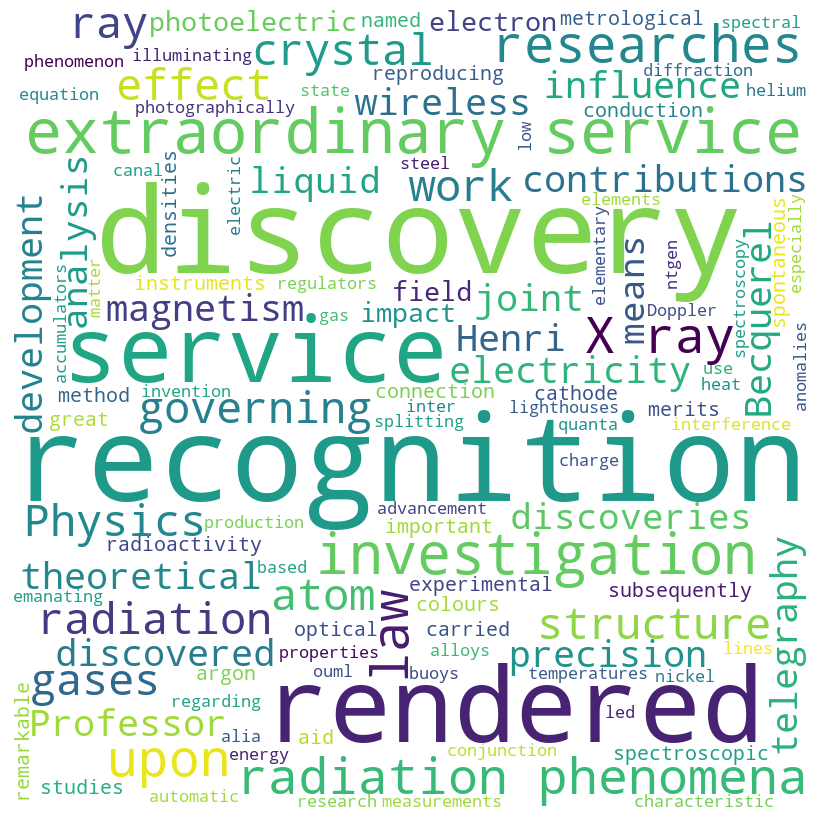

In [2]:
url = "http://api.nobelprize.org/2.1/nobelPrizes"
# Nobel prize in physics only
params = {
    "nobelPrizeCategory": "phy",
}

# Make the call
response = requests.get(url, params=params)

# is the call ok?
if response.status_code != 200:
    raise Exception(f"Failed call, status: {response.status_code}")

# extract the words from english motivation
words = ""
for prize in response.json().get("nobelPrizes", []):
    for laureate in prize.get("laureates", []):
        motivation = laureate.get("motivation", {}).get("en", "")
        if motivation:
            words += f" {motivation}"

# Generate word cloud by following the example at https://www.geeksforgeeks.org/generating-word-cloud-python/
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(words)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Part 2 - web scraping

We need to scrape following url's:
- https://books.toscrape.com/catalogue/page-1.html
- https://books.toscrape.com/catalogue/page-2.html
- https://books.toscrape.com/catalogue/page-3.html
and we do that with the library beautiful soup.

Example of how a book on this page look:
```html
<article class="product_pod">
<div class="image_container">
<a href="a-light-in-the-attic_1000/index.html"><img alt="A Light in the Attic" class="thumbnail" src="../media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/></a>
</div>
<p class="star-rating Three">
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
</p>
<h3><a href="a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
<div class="product_price">
<p class="price_color">£51.77</p>
<p class="instock availability">
<i class="icon-ok"></i>
    
        In stock
    
</p>
<form>
<button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>
</form>
</div>
</article>
```

The UPC is only available when clicking on the details for each book, so we need to scrape that too by navigating to a link like https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html
The indiviual book page is huge, so I'm not including an example of it here, but remove the comment in front of print(book_detail_parsed_html) to see it. The interesting part looks like this: 
```html
<th>UPC</th><td>a897fe39b1053632</td>
```
. To find the UPC we look for <th>UPC</th> and find the next td which contains the actual UPC. Code: book_detail.find("th", text="UPC").find_next_sibling("td").text

The rest of the information we take from the overview page:
To find the title we parse something like:
```html
<h3><a href="a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
```
so code title = book.h3.a["title"]

To find the price we parse something like
```html
<p class="price_color">£51.77</p>
```
so code book.find("p", class_="price_color").text

To find the star rating we parse something like
```html
<p class="star-rating Three">
```
so code book.p["class"][-1]. We need the -1 as book.p["class"] returns a list and the last element in that list has the star rating. Example of the list: ['star-rating', 'Three'].


In [3]:
# Create a data frame to store the result in
books_df = pd.DataFrame(columns=["upc", "title", "price", "rating"])

# 3 pages looking like https://books.toscrape.com/catalogue/page-XXX.html
url = "https://books.toscrape.com/catalogue/page-{}.html"
for page in range(1, 4):
    response = requests.get(url.format(page))
    parsed_html = BeautifulSoup(response.content, "html.parser")
    
    # each page has many books(should be 20)
    books = parsed_html.find_all("article", class_="product_pod")
    for book in books:
        #print(book) # this is used to provide the example in the description above
        
        # the UPC is not available on the overview page, so navigate one more page
        book_url = book.h3.a["href"]
        book_response = requests.get(f"https://books.toscrape.com/catalogue/{book_url}")
        book_detail_parsed_html = BeautifulSoup(book_response.content, "html.parser")
        #print(book_detail_parsed_html) # uncomment this to get an example of the details
        upc = book_detail_parsed_html.find("th", text="UPC").find_next_sibling("td").text
        
        # title, price, rating we can scrape from the summary page
        title = book.h3.a["title"]
        price = book.find("p", class_="price_color").text
        rating = book.p["class"][-1]

        # append to the data frame with ignore_index=True so we get correct index(and not just 0 as index)
        books_df = pd.concat([books_df, pd.DataFrame([{"upc": upc, "title": title, "price": price, "rating": rating}])], ignore_index=True)

# Print the table
books_df


,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
5,f77dbf2323deb740,The Requiem Red,£22.65,One
6,2597b5a345f45e1b,The Dirty Little Secrets of Getting Your Dream...,£33.34,Four
7,e72a5dfc7e9267b2,The Coming Woman: A Novel Based on the Life of...,£17.93,Three
8,e10e1e165dc8be4a,The Boys in the Boat: Nine Americans and Their...,£22.60,Four
9,1dfe412b8ac00530,The Black Maria,£52.15,One
